## We solve the MHD toy model with PINN

### The evolution equations are:

$$
\partial_t B^i = \nabla_j (v^j B^i - v^i B^j) \;\;\;\; \nabla_i B^i = 0
$$

The vector field $v^i$ is given. 

And we impose Dirichlet boundary conditions.

The initial data is: 

\begin{align*}
B_1 &= \partial_y \phi \\
B_2 &= -\partial_x \phi
\end{align*}
with (here we use xmin=0, xmax = 1, same for y)

$$
\phi(x,y) = (x*(x-1)*y*(y-1))^2
$$

The velocity field is time-independent and given by:

\begin{align*}
v1(t,x,y) &= \sin(\pi*x)*\cos(\pi*y) \\
v2(t,x,y) &= \cos(\pi*x)*\sin(\pi*y) \\
\end{align*}



In [2]:
using NeuralPDE, Optimization, OptimizationOptimJL, Roots,
      LineSearches, Random 
#using CUDA
using ModelingToolkit, IntervalSets 
using IntervalSets
using Plots, Printf
using Lux, LuxCUDA, ComponentArrays, Random
using JLD2, LinearAlgebra 
const gpud = gpu_device()
using SymbolicUtils


@parameters t, x, y
@variables B1(..), B2(..)
Dx = Differential(x)
Dy = Differential(y)
Dt = Differential(t)

Differential(t)

In [3]:
# -------------------------------------------------------------------
# Configuración
# -------------------------------------------------------------------
config = Dict(
    :N_input => 3,          # [t , x, y]
    :N_neurons => 64,
    :N_layers => 3,
    :N_output => 1, 
    :N_points => 150_000,     # puntos de colisión (x,t)
    :xmin => 0.0,
    :xmax => 1.0,           # = L dominio espacial
    :ymin => 0.0,
    :ymax => 1.0,           # = L dominio espacial
    :tmin => 0.0,           # t_min
    :tmax => 2.0,           # t_max
    :optimizer => BFGS(),
    :maxiters => 30_000,
    # for the initial data
    :A => 1.0,
    :p => 2,
    :c => 1.0,
    # for discretizations
    :dx => [0.1, 0.1, 0.1]
)

Dict{Symbol, Any} with 17 entries:
  :xmin      => 0.0
  :tmax      => 2.0
  :maxiters  => 30000
  :xmax      => 1.0
  :A         => 1.0
  :p         => 2
  :N_input   => 3
  :N_output  => 1
  :ymax      => 1.0
  :c         => 1.0
  :tmin      => 0.0
  :N_layers  => 3
  :optimizer => BFGS{InitialStatic{Float64}, HagerZhang{Float64, RefValue{Bool}…
  :N_points  => 150000
  :ymin      => 0.0
  :dx        => [0.1, 0.1, 0.1]
  :N_neurons => 64

In [4]:
# Space and time domains

@show domains = [t ∈ Interval(config[:tmin], config[:tmax]),
    x ∈ Interval(config[:xmin], config[:xmax]), y ∈ Interval(config[:ymin], config[:ymax])]
# Discretization
dx = config[:dx]

domains = [t ∈ Interval(config[:tmin], config[:tmax]), x ∈ Interval(config[:xmin], config[:xmax]), y ∈ Interval(config[:ymin], config[:ymax])] = Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 2.0), Symbolics.VarDomainPairing(x, 0.0 .. 1.0), Symbolics.VarDomainPairing(y, 0.0 .. 1.0)]


3-element Vector{Float64}:
 0.1
 0.1
 0.1

In [10]:
#v1(t,x,y) = cos(pi*x)
#v2(t,x,y) = cos(pi*y) # with minus is divergence free

r = sqrt(x^2 + y^2)
v1(t,x,y) = x*r*(r - 0.5)/(r+0.5)
v2(t,x,y) = y*r*(r - 0.5)/(r+0.5) 

v2 (generic function with 1 method)

In [13]:
xs, ys = [0.0:0.01:1.0 for d in domains]

v1_d = [v1(0.0, x, y) for x in xs for y in ys]
v2_d = [v2(0.0, x, y) for x in xs for y in ys]
#pv1 = plot(xs, ys, v1_d, linetype = :contourf, title = "v1", aspect_ratio = 1)
#pv2 = plot(xs, ys, v2_d, linetype = :contourf, title = "v2", aspect_ratio = 1)
#plot(pv1, pv2, layout = (1,2))

10201-element Vector{Num}:
                                                                      0.0
 (0.01(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.02(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.03(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.04(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.05(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.06(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.07(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.08(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.09(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
                                                                        ⋮
 (0.92(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.93(-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 (0.94(-0.5

In [14]:
v1_d

10201-element Vector{Num}:
                                                                  0.0
                                                                  0.0
                                                                  0.0
                                                                  0.0
                                                                  0.0
                                                                  0.0
                                                                  0.0
                                                                  0.0
                                                                  0.0
                                                                  0.0
                                                                    ⋮
 ((-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 ((-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 + y^2))
 ((-0.5 + sqrt(x^2 + y^2))*sqrt(x^2 + y^2)) / (0.5 + sqrt(x^2 +

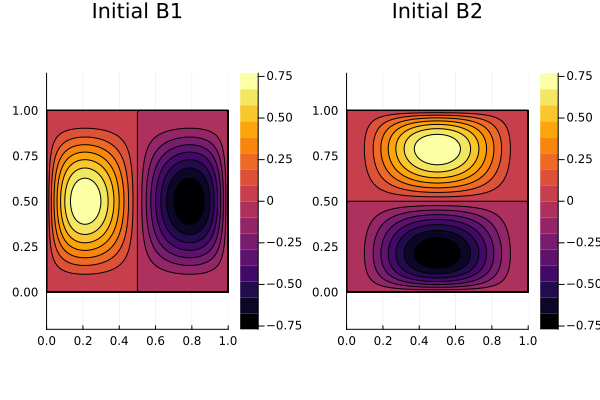

In [6]:
B1_d = [ y*(y-1)*(2y-1)*x^2*(x-1)^2*128 for x in xs for y in ys]
B2_d = [ -x*(x-1)*(2x-1)*y^2*(y-1)^2*128 for x in xs for y in ys]
pv1 = plot(xs, ys, B1_d, linetype = :contourf, title = "Initial B1", aspect_ratio = 1)
pv2 = plot(xs, ys, B2_d, linetype = :contourf, title = "Initial B2", aspect_ratio = 1)
plot(pv1, pv2, layout = (1,2))

In [7]:

eqs = [Dt(B1(t,x,y)) ~ Dy(v2(t,x,y)*B1(t,x,y) - v1(t,x,y)*B2(t,x,y)), 
    Dt(B2(t,x,y)) ~ Dx(v1(t,x,y)*B2(t,x,y) - v2(t,x,y)*B1(t,x,y)), 
    Dx(B1(t,x,y)) + Dy(B2(t,x,y))  ~ 0]


3-element Vector{Equation}:
 Differential(t)(B1(t, x, y)) ~ Differential(y)((-x*B2(t, x, y)*(-0.5 + sqrt(x^2 + y^2))) / (0.5 + sqrt(x^2 + y^2)) + (y*B1(t, x, y)*(-0.5 + sqrt(x^2 + y^2))) / (0.5 + sqrt(x^2 + y^2)))
 Differential(t)(B2(t, x, y)) ~ Differential(x)((x*B2(t, x, y)*(-0.5 + sqrt(x^2 + y^2))) / (0.5 + sqrt(x^2 + y^2)) + (-y*B1(t, x, y)*(-0.5 + sqrt(x^2 + y^2))) / (0.5 + sqrt(x^2 + y^2)))
 Differential(y)(B2(t, x, y)) + Differential(x)(B1(t, x, y)) ~ 0

### Boundary conditions

Using the constraint the equations are equivalent to:

$$
\partial_t B^i = v^j\partial_j B^i + l.o.t.
$$
Thus, at the boundaries we have to impose boundary conditions (non-incoming in our case) only when
$v^jn_j \geq 0$.

Otherwise we could put periodic boundary conditions by imposing for instance $B^i(t,0,y) = B^i(t,L,y)$


In [1]:
non_incoming = true
#periodic = true
if non_incoming 
bcs = [B1(0,x,y) ~ Dy(phi(x,y)),
    B2(0,x,y) ~ -Dx(phi(x,y)),
    (1 - sign(v1(t,0,y)))*sign(v1(t,0,y))*B1(t,0,y) ~ 0,
    (1 + sign(v1(t,1,y)))*sign(v1(t,1,y))*B1(t,1,y) ~ 0,
    (1 - sign(v2(t,x,0)))*sign(v2(t,x,0))*B1(t,x,0) ~ 0,
    (1 + sign(v2(t,x,1)))*sign(v2(t,x,1))*B1(t,x,1) ~ 0,
    (1 - sign(v1(t,0,y)))*sign(v1(t,0,y))*B2(t,0,y) ~ 0,
    (1 + sign(v1(t,1,y)))*sign(v1(t,1,y))*B2(t,1,y) ~ 0,
    (1 - sign(v2(t,x,0)))*sign(v2(t,x,0))*B2(t,x,0) ~ 0,
    (1 + sign(v2(t,x,1)))*sign(v2(t,x,1))*B2(t,x,1) ~ 0]

elseif periodic

    bcs = [B1(0,x,y) ~ Dy(phi(x,y)),
    B2(0,x,y) ~ -Dx(phi(x,y)),
    B1(t,0,y) ~ B1(t,1,y),
    B1(t,x,0) ~ B1(t,x,1),
    B2(t,0,y) ~ B2(t,1,y),
    B2(t,x,0) ~ B2(t,x,1)]
end


UndefVarError: UndefVarError: `B1` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [10]:
# Neural network
input_ = length(domains)
n = config[:N_neurons]
chain = [Chain(Dense(input_, n, σ), Dense(n, n, σ), Dense(n, 1)) for _ in 1:2]

#strategy = QuadratureTraining()
#strategy = QuasiRandomTraining(100)
strategy = GridTraining(dx)
#ps = Lux.setup(Random.default_rng(), chain)[1] 
#ps = ps |> ComponentArray |> gpud
discretization = PhysicsInformedNN(chain, strategy) #; init_params = ps)

@named MHD_toy = PDESystem(eqs, bcs, domains, [t, x, y], [B1(t, x, y), B2(t, x, y)])
prob = discretize(MHD_toy, discretization)
sym_prob = symbolic_discretize(MHD_toy, discretization)

pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions

loss = Float64[]

callback = function (p, l)
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p.u), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p.u), bcs_inner_loss_functions))
    push!(loss, l)
    return false
end


#33 (generic function with 1 method)

In [ ]:

res = Optimization.solve(prob, BFGS(linesearch = BackTracking()); maxiters = config[:maxiters], callback)


In [ ]:
plot(loss, yscale = :log10, title = "Loss history", xlabel = "Iteration", ylabel = "Loss")

In [ ]:
phi_d = discretization.phi

In [ ]:
depvars = [:B1, :B2]
minimizers_ = [res.u.depvar[depvars[i]] for i in 1:length(chain)]

@save "toy_MHD_2D.jld2" config domains eqs bcs depvars minimizers_ phi_d loss